### Display Directory Tree Structure

In [40]:
import os

# Skip file extensions and folder names
SKIP_EXTENSIONS = {".jpg", ".png", ".mat", ".bmp", ".jpeg" ,".txt", ".db", ".gitsave", ".pth"}
SKIP_DIR_NAMES = {"__pycache__", ".ipynb_checkpoints"}

def print_tree(root_path, indent="", max_items=10):
    try:
        items = os.listdir(root_path)
    except PermissionError:
        print(indent + "Permission denied")
        return

    # Filter items
    filtered = []
    for item in sorted(items):
        full_path = os.path.join(root_path, item)
        if os.path.isdir(full_path):
            if item in SKIP_DIR_NAMES:
                continue
        else:
            _, ext = os.path.splitext(item)
            if ext.lower() in SKIP_EXTENSIONS:
                continue
        filtered.append(item)

    total_items = len(filtered)
    display_items = filtered[:max_items]

    for i, item in enumerate(display_items):
        full_path = os.path.join(root_path, item)
        is_last = (i == len(display_items) - 1)
        prefix = "└── " if is_last else "├── "
        print(indent + prefix + item)

        if os.path.isdir(full_path):
            new_indent = indent + ("    " if is_last else "│   ")
            print_tree(full_path, new_indent, max_items)

    if total_items > max_items:
        print(indent + "│   ...")

if __name__ == "__main__":
    root_directory = "." 
    print(root_directory)
    print_tree(root_directory)


.
├── Fashionpedia.ipynb
└── data
    ├── annotations
    │   ├── instances_attributes_train2020.json
    │   └── instances_attributes_val2020.json
    ├── test
    └── train


### Import Core Libraries and Modules

In [1]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Set Dataset Paths and Constants

In [2]:
import numpy as np
from pycocotools import mask as coco_mask

# Set base path
BASE_DIR = '/home/moh/scripts/capstone/Fashionpedia'
IMAGE_DIR_TRAIN = os.path.join(BASE_DIR, 'data/train')
IMAGE_DIR_VAL = os.path.join(BASE_DIR, 'data/test')
ANNOTATION_TRAIN = os.path.join(BASE_DIR, 'data/annotations/instances_attributes_train2020.json')
ANNOTATION_VAL = os.path.join(BASE_DIR, 'data/annotations/instances_attributes_val2020.json')

### Load and Inspect COCO-style Annotations

In [3]:
# Load JSON annotations
with open(ANNOTATION_TRAIN, 'r') as f:
    annotation_train = json.load(f)

with open(ANNOTATION_VAL, 'r') as f:
    annotation_val = json.load(f)

# Inspect the top-level keys
print("Train annotation keys:", annotation_train.keys())
print("Val annotation keys:", annotation_val.keys())

# check how many entries in each key
for key in ['images', 'annotations', 'categories', 'attributes']:
    print(f"{key} (train):", len(annotation_train.get(key, [])))


Train annotation keys: dict_keys(['annotations', 'images', 'info', 'licenses', 'categories', 'attributes'])
Val annotation keys: dict_keys(['info', 'categories', 'attributes', 'licenses', 'annotations', 'images'])
images (train): 45623
annotations (train): 333401
categories (train): 46
attributes (train): 294


### Create Category and Attribute Maps

In [4]:
# Build ID to category name map
category_id_to_name = {cat["id"]: cat["name"] for cat in annotation_train["categories"]}
attribute_id_to_name = {attr["id"]: attr["name"] for attr in annotation_train["attributes"]}

# Optionally: Build category supercategories and levels
category_info = {
    cat["id"]: {
        "name": cat["name"],
        "supercategory": cat["supercategory"],
        "level": cat["level"],
        "taxonomy_id": cat["taxonomy_id"]
    }
    for cat in annotation_train["categories"]
}

attribute_info = {
    attr["id"]: {
        "name": attr["name"],
        "supercategory": attr["supercategory"],
        "level": attr["level"],
        "taxonomy_id": attr["taxonomy_id"]
    }
    for attr in annotation_train["attributes"]
}

# Preview
print("Sample category map:", list(category_id_to_name.items())[:5])
print("Sample attribute map:", list(attribute_id_to_name.items())[:5])


Sample category map: [(0, 'shirt, blouse'), (1, 'top, t-shirt, sweatshirt'), (2, 'sweater'), (3, 'cardigan'), (4, 'jacket')]
Sample attribute map: [(0, 'classic (t-shirt)'), (1, 'polo (shirt)'), (2, 'undershirt'), (3, 'henley (shirt)'), (4, 'ringer (t-shirt)')]


### Count and Display Category Frequencies

In [5]:
from collections import Counter
import pandas as pd

# Count how often each category ID appears
category_counter = Counter()
for ann in annotation_train["annotations"]:
    category_counter[ann["category_id"]] += 1

# Convert to a readable DataFrame
category_freq_df = pd.DataFrame([
    {"Category ID": cat_id, "Name": category_id_to_name[cat_id], "Count": count}
    for cat_id, count in category_counter.items()
]).sort_values("Count", ascending=False)

# Show top 10 most common categories
print(category_freq_df)


    Category ID                                     Name  Count
1            31                                   sleeve  59448
6            23                                     shoe  46374
11           33                                 neckline  34258
0            32                                   pocket  27179
5            10                                    dress  18739
16            1                 top, t-shirt, sweatshirt  16548
12            6                                    pants  12414
3            28                                   collar  10159
17           35                                   zipper   7991
20            4                                   jacket   7833
10           24                              bag, wallet   7217
9            19                                     belt   6851
4             0                            shirt, blouse   6161
19           29                                    lapel   5972
30           37                         

### Count and Display Attribute Frequencies

In [6]:
attribute_counter = Counter()
for ann in annotation_train["annotations"]:
    for attr_id in ann.get("attribute_ids", []):
        attribute_counter[attr_id] += 1

# Convert to DataFrame
attribute_freq_df = pd.DataFrame([
    {"Attribute ID": attr_id, "Name": attribute_id_to_name[attr_id], "Count": count}
    for attr_id, count in attribute_counter.items()
]).sort_values("Count", ascending=False)

# Show most common and least common
print(attribute_freq_df.head(10))
print("\n---\n")
print(attribute_freq_df.tail(10))


    Attribute ID                                Name  Count
6            295             no non-textile material  65854
9            115                         symmetrical  60164
13           317                     plain (pattern)  58468
1            204                       set-in sleeve  39004
12           316  no special manufacturing technique  38349
14           160                        wrist-length  34135
30           142                        normal waist  25019
35           136                       regular (fit)  24669
8            145                        no waistline  18942
48           146              above-the-hip (length)  17444

---

     Attribute ID              Name  Count
254            75    sarong (skirt)     11
279            66     cargo (skirt)      9
198           171    jabot (collar)      8
268            61          bloomers      5
277            56             skort      5
286           294              wood      4
260            25      mao (jacke

### Filter Rare Categories and Attributes

In [7]:
# Thresholds
MIN_CATEGORY_COUNT = 500
MIN_ATTRIBUTE_COUNT = 500

# Split categories
kept_categories = {cat_id: category_id_to_name[cat_id] for cat_id, count in category_counter.items() if count >= MIN_CATEGORY_COUNT}
removed_categories = {cat_id: category_id_to_name[cat_id] for cat_id, count in category_counter.items() if count < MIN_CATEGORY_COUNT}

# Split attributes
kept_attributes = {attr_id: attribute_id_to_name[attr_id] for attr_id, count in attribute_counter.items() if count >= MIN_ATTRIBUTE_COUNT}
removed_attributes = {attr_id: attribute_id_to_name[attr_id] for attr_id, count in attribute_counter.items() if count < MIN_ATTRIBUTE_COUNT}

# Print counts
print(f"✔ Kept categories: {len(kept_categories)}")
print(f"✘ Removed categories: {len(removed_categories)}")
print(f"✔ Kept attributes: {len(kept_attributes)}")
print(f"✘ Removed attributes: {len(removed_attributes)}")

# Print full lists
print("\n--- Kept Categories ---")
for k, v in kept_categories.items():
    print(f"{k}: {v}")

print("\n--- Removed Categories ---")
for k, v in removed_categories.items():
    print(f"{k}: {v}")

print("\n--- Kept Attributes ---")
for k, v in kept_attributes.items():
    print(f"{k}: {v}")

print("\n--- Removed Attributes ---")
for k, v in removed_attributes.items():
    print(f"{k}: {v}")


✔ Kept categories: 41
✘ Removed categories: 5
✔ Kept attributes: 133
✘ Removed attributes: 161

--- Kept Categories ---
32: pocket
31: sleeve
22: sock
28: collar
0: shirt, blouse
10: dress
23: shoe
21: tights, stockings
13: glasses
19: belt
24: bag, wallet
33: neckline
6: pants
27: hood
30: epaulette
9: coat
1: top, t-shirt, sweatshirt
35: zipper
14: hat
29: lapel
4: jacket
39: flower
43: ruffle
36: applique
8: skirt
34: buckle
25: scarf
17: glove
7: shorts
11: jumpsuit
37: bead
18: watch
16: tie
15: headband, head covering, hair accessory
40: fringe
42: rivet
2: sweater
3: cardigan
5: vest
44: sequin
38: bow

--- Removed Categories ---
26: umbrella
41: ribbon
12: cape
45: tassel
20: leg warmer

--- Kept Attributes ---
218: patch (pocket)
204: set-in sleeve
205: dropped-shoulder sleeve
159: three quarter (length)
163: shirt (collar)
225: single breasted
295: no non-textile material
137: loose (fit)
145: no waistline
115: symmetrical
148: micro (length)
149: mini (length)
316: no specia

### Clean Validation Annotations Based on Filters

In [8]:
# Clean validation annotations using kept_categories and kept_attributes
cleaned_annotations_val = []

for ann in annotation_val["annotations"]:
    cat_id = ann["category_id"]
    attr_ids = ann.get("attribute_ids", [])

    filtered_attrs = [a for a in attr_ids if a in kept_attributes]

    if cat_id in kept_categories and filtered_attrs:
        new_ann = ann.copy()
        new_ann["attribute_ids"] = filtered_attrs
        cleaned_annotations_val.append(new_ann)

print(f"Original val annotations: {len(annotation_val['annotations'])}")
print(f"Filtered val annotations: {len(cleaned_annotations_val)}")


Original val annotations: 8781
Filtered val annotations: 5126


### Clean Training Annotations Based on Filters

In [9]:
# Prepare final cleaned annotation list
cleaned_annotations = []

for ann in annotation_train["annotations"]:
    cat_id = ann["category_id"]
    attr_ids = ann.get("attribute_ids", [])

    # Keep only valid attribute IDs
    filtered_attrs = [a for a in attr_ids if a in kept_attributes]

    # Filter condition: category must be valid AND at least one valid attribute remains
    if cat_id in kept_categories and filtered_attrs:
        new_ann = ann.copy()
        new_ann["attribute_ids"] = filtered_attrs
        cleaned_annotations.append(new_ann)

print(f"Original annotations: {len(annotation_train['annotations'])}")
print(f"Filtered annotations: {len(cleaned_annotations)}")


Original annotations: 333401
Filtered annotations: 202569


### Visualize Annotations on Sample Images

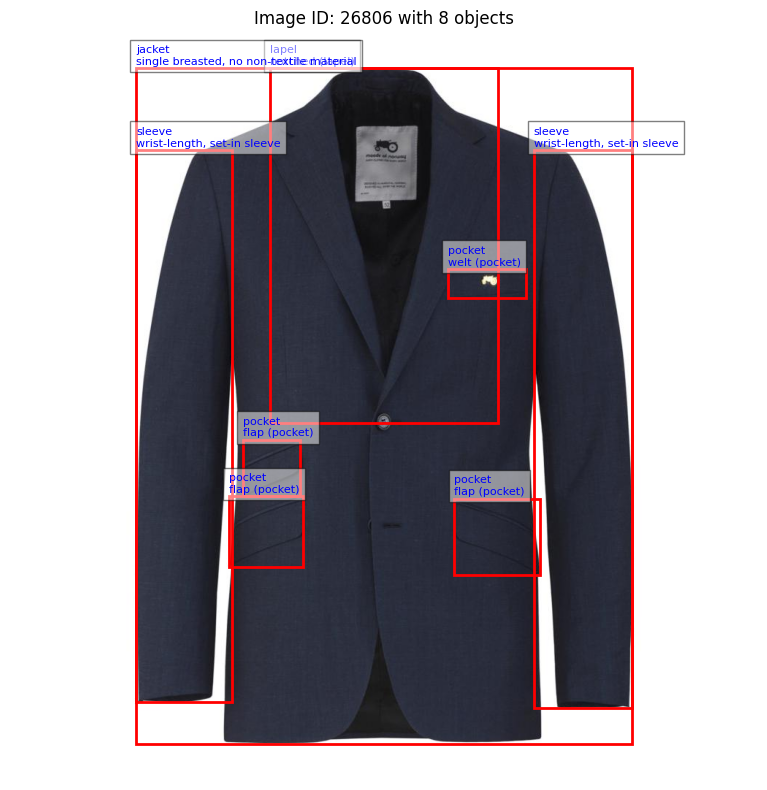

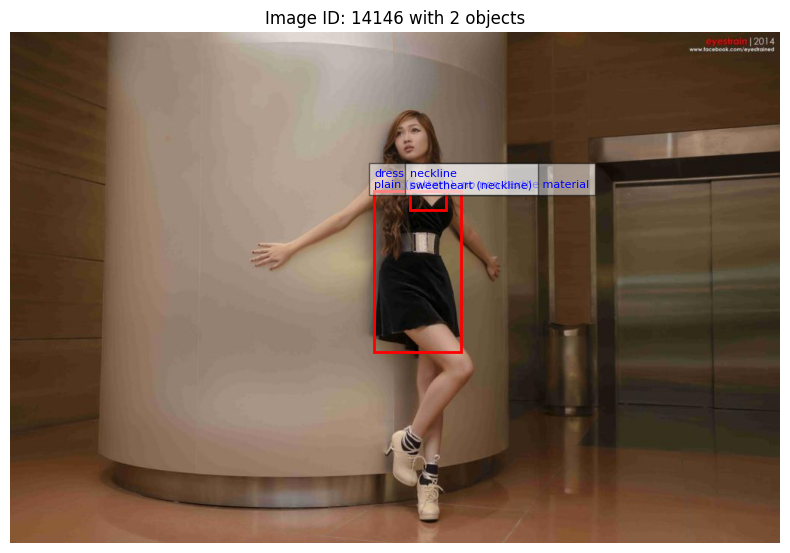

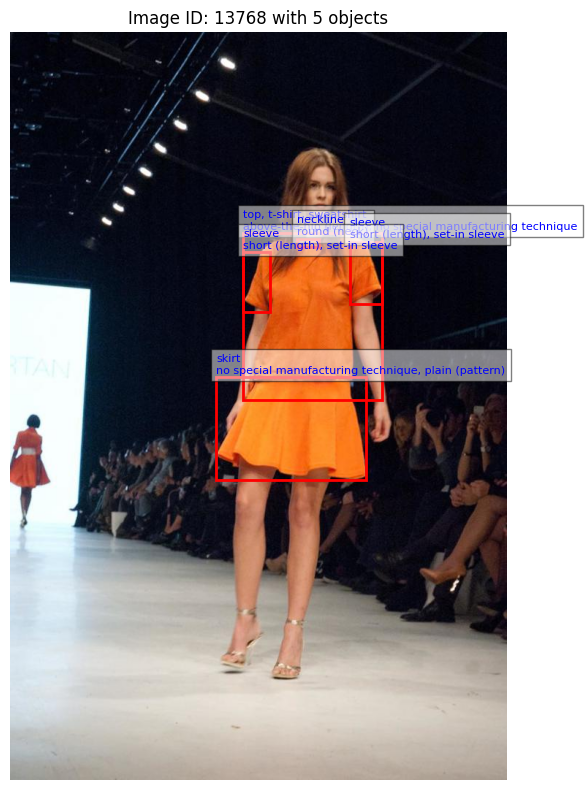

In [10]:
import random
import matplotlib.patches as patches

def show_image_with_all_annotations(n=3):
    shown = 0
    used_ids = set()

    while shown < n:
        ann = random.choice(cleaned_annotations)
        image_id = ann["image_id"]
        
        if image_id in used_ids:
            continue
        used_ids.add(image_id)

        # Get image info and path
        image_info = next(img for img in annotation_train["images"] if img["id"] == image_id)
        image_path = os.path.join(IMAGE_DIR_TRAIN, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")

        # Get all annotations for this image
        anns = [a for a in cleaned_annotations if a["image_id"] == image_id]

        # Draw image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        ax = plt.gca()

        for a in anns:
            x, y, w, h = a["bbox"]
            cat_name = category_id_to_name[a["category_id"]]
            attr_names = [attribute_id_to_name[attr] for attr in a["attribute_ids"]]
            label_text = f"{cat_name}\n" + ", ".join(attr_names[:2])  # limit attributes

            # Draw box
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, label_text, fontsize=8, color='blue', bbox=dict(facecolor='white', alpha=0.5))

        plt.axis("off")
        plt.title(f"Image ID: {image_id} with {len(anns)} objects")
        plt.tight_layout()
        plt.show()

        shown += 1

# Show 3 full-image visualizations
show_image_with_all_annotations(n=3)



### Define FashionpediaDataset Class

In [11]:
from torch.utils.data import Dataset
from PIL import Image
import torch
from collections import defaultdict
import os

class FashionpediaDataset(Dataset):
    def __init__(self, image_dir, annotations, valid_attr_ids, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.valid_attr_ids = valid_attr_ids
        self.attr_id_to_idx = {aid: idx for idx, aid in enumerate(valid_attr_ids)}

        # Map image_id → list of annotations
        self.image_id_to_anns = defaultdict(list)
        for ann in annotations:
            filtered_attrs = [aid for aid in ann.get("attribute_ids", []) if aid in valid_attr_ids]
            if filtered_attrs:
                ann = ann.copy()
                ann["attribute_ids"] = filtered_attrs
                self.image_id_to_anns[ann["image_id"]].append(ann)

        self.image_ids = list(self.image_id_to_anns.keys())

    def set_image_paths(self, image_metadata):
        self.image_id_to_path = {img["id"]: os.path.join(self.image_dir, img["file_name"]) for img in image_metadata}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        anns = self.image_id_to_anns[image_id]

        img_path = self.image_id_to_path[image_id]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label_tensor = torch.zeros(len(self.valid_attr_ids), dtype=torch.float32)
        for ann in anns:
            for aid in ann["attribute_ids"]:
                label_tensor[self.attr_id_to_idx[aid]] = 1.0

        return {
            "image": image,
            "attribute_labels": label_tensor
        }


### Define Image Transformations

In [12]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((231, 93)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


### Initialize Training and Validation Datasets

In [13]:
# Init
train_dataset = FashionpediaDataset(
    image_dir=IMAGE_DIR_TRAIN,
    annotations=cleaned_annotations,
    valid_attr_ids=list(kept_attributes.keys()),
    transform=transform
)
train_dataset.set_image_paths(annotation_train["images"])

val_dataset = FashionpediaDataset(
    image_dir=IMAGE_DIR_VAL,
    annotations=cleaned_annotations_val,
    valid_attr_ids=list(kept_attributes.keys()),
    transform=transform
)
val_dataset.set_image_paths(annotation_val["images"])


### Create DataLoaders for Train and Val Sets

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)


### Define ResNet50-Based Multi-Label Model

In [15]:
import torch.nn as nn
from torchvision import models

class FashionpediaModel(nn.Module):
    def __init__(self, num_attributes):
        super(FashionpediaModel, self).__init__()
        base = models.resnet50(weights="IMAGENET1K_V1")
        in_features = base.fc.in_features
        base.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_attributes)
        )
        self.model = base

    def forward(self, x):
        return self.model(x)


### Implement Training Loop with Validation

In [16]:
import torch
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from contextlib import nullcontext

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, num_epochs=30, early_stop_patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for batch in tqdm(train_loader, desc="Training", leave=False):
            images = batch["image"].to(device)
            labels = batch["attribute_labels"].to(device)

            optimizer.zero_grad()
            with autocast(device_type='cuda') if device.type == "cuda" else nullcontext():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).float().sum().item()
            total += labels.numel()

        scheduler.step()
        avg_train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                images = batch["image"].to(device)
                labels = batch["attribute_labels"].to(device)
                with autocast(device_type='cuda') if device.type == "cuda" else nullcontext():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).float().sum().item()
                val_total += labels.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        # Print both train and val metrics together
        print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_acc:.2f}%")
        print(f"Val   Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_fashionpedia_model.pth")
            print("### Validation improved. Model saved ###")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print("Early stopping triggered.")
                break



### Train Model with Early Stopping

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionpediaModel(num_attributes=len(kept_attributes)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()

print(f"Using device: {device}")
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device)


Using device: cuda

Epoch 1/30


Train Loss: 0.1840 | Accuracy: 93.35%
Val   Loss: 0.1859 | Accuracy: 93.36%
### Validation improved. Model saved ###

Epoch 2/30


Train Loss: 0.1593 | Accuracy: 94.07%
Val   Loss: 0.1810 | Accuracy: 93.50%
### Validation improved. Model saved ###

Epoch 3/30


Train Loss: 0.1483 | Accuracy: 94.40%
Val   Loss: 0.1787 | Accuracy: 93.51%
### Validation improved. Model saved ###

Epoch 4/30


Train Loss: 0.1390 | Accuracy: 94.72%
Val   Loss: 0.1771 | Accuracy: 93.60%
### Validation improved. Model saved ###

Epoch 5/30


Train Loss: 0.1300 | Accuracy: 95.03%
Val   Loss: 0.1828 | Accuracy: 93.51%

Epoch 6/30


Train Loss: 0.1140 | Accuracy: 95.66%
Val   Loss: 0.1803 | Accuracy: 93.60%

Epoch 7/30


Train Loss: 0.1070 | Accuracy: 95.96%
Val   Loss: 0.1817 | Accuracy: 93.56%

Epoch 8/30


Train Loss: 0.1019 | Accuracy: 96.17%
Val   Loss: 0.1846 | Accuracy: 93.54%

Epoch 9/30


Train Loss: 0.0973 | Accuracy: 96.37%
Val   Loss: 0.1893 | Accuracy: 93.44%
Early stopping triggered.


### Prepare Test Dataset and DataLoader

In [18]:
test_dataset = FashionpediaDataset(
    image_dir=IMAGE_DIR_VAL,
    annotations=cleaned_annotations_val,
    valid_attr_ids=list(kept_attributes.keys()),
    transform=transform
)
test_dataset.set_image_paths(annotation_val["images"])

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)


### Evaluate Model and Generate Classification Report

In [21]:
from sklearn.metrics import classification_report
import numpy as np

# Load best model
model.load_state_dict(torch.load("best_fashionpedia_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        images = batch["image"].to(device)
        labels = batch["attribute_labels"].to(device)

        with autocast(device_type=device.type) if device.type == "cuda" else nullcontext():
            outputs = model(images)
            probs = torch.sigmoid(outputs)

        preds = (probs > 0.5).float()
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Combine
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Generate report
print(classification_report(
    all_labels,
    all_preds,
    target_names=[attribute_id_to_name[aid] for aid in kept_attributes.keys()],
    zero_division=0
))


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:02<00:00, 18.04it/s]

                                    precision    recall  f1-score   support

                    patch (pocket)       0.35      0.07      0.12        87
                     set-in sleeve       0.71      0.78      0.74       449
           dropped-shoulder sleeve       0.40      0.05      0.08        44
            three quarter (length)       0.36      0.10      0.16        77
                    shirt (collar)       0.55      0.35      0.42        84
                   single breasted       0.60      0.42      0.49       198
           no non-textile material       0.92      1.00      0.96      1061
                       loose (fit)       0.62      0.04      0.08       195
                      no waistline       0.78      0.61      0.68       462
                       symmetrical       0.97      0.99      0.98      1117
                    micro (length)       0.90      0.09      0.16       101
                     mini (length)       0.72      0.69      0.70       323
no special 

### Predict Attributes for a Single Test Image

In [39]:
from PIL import Image
import torch

image_path = os.path.join("cs.png")

# Preprocess
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    with autocast(device_type=device.type) if device.type == "cuda" else nullcontext():
        output = model(input_tensor)
        probs = torch.sigmoid(output).squeeze()

# Decode
predicted_attrs = [
    attribute_id_to_name[aid]
    for i, aid in enumerate(kept_attributes.keys())
    if probs[i].item() > 0.5
]

print("Predicted Attributes:")
for attr in predicted_attrs:
    print(f"- {attr}")


Predicted Attributes:
- no non-textile material
- symmetrical
- no special manufacturing technique
- plain (pattern)
- tight (fit)
- normal waist
- jeans
- fly (opening)
- maxi (length)
